In [12]:
import PyQt5
%matplotlib inline
import numpy as np
from math import asinh, atan, sqrt, pi, sin
import matplotlib.pyplot as plt

In [38]:
# setup mesh and material constants
n     = (100, 25, 1)
dx    = (5e-9, 5e-9, 3e-9)
mu0   = 4e-7 * pi
gamma = 2.211e5
ms    = 8e5
A     = 1.3e-11
alpha = 0.02

# a very small number
eps = 1e-18

# newell f
def f(p):
  x, y, z = abs(p[0]), abs(p[1]), abs(p[2])
  return + y / 2.0 * (z**2 - x**2) * asinh(y / (sqrt(x**2 + z**2) + eps)) \
         + z / 2.0 * (y**2 - x**2) * asinh(z / (sqrt(x**2 + y**2) + eps)) \
         - x*y*z * atan(y*z / (x * sqrt(x**2 + y**2 + z**2) + eps))       \
         + 1.0 / 6.0 * (2*x**2 - y**2 - z**2) * sqrt(x**2 + y**2 + z**2)

# newell g
def g(p):
  x, y, z = p[0], p[1], abs(p[2])
  return + x*y*z * asinh(z / (sqrt(x**2 + y**2) + eps))                         \
         + y / 6.0 * (3.0 * z**2 - y**2) * asinh(x / (sqrt(y**2 + z**2) + eps)) \
         + x / 6.0 * (3.0 * z**2 - x**2) * asinh(y / (sqrt(x**2 + z**2) + eps)) \
         - z**3 / 6.0 * atan(x*y / (z * sqrt(x**2 + y**2 + z**2) + eps))        \
         - z * y**2 / 2.0 * atan(x*z / (y * sqrt(x**2 + y**2 + z**2) + eps))    \
         - z * x**2 / 2.0 * atan(y*z / (x * sqrt(x**2 + y**2 + z**2) + eps))    \
         - x*y * sqrt(x**2 + y**2 + z**2) / 3.0

# demag tensor setup
def set_n_demag(c, permute, func):
  it = np.nditer(n_demag[:,:,:,c], flags=['multi_index'], op_flags=['writeonly'])
  while not it.finished:
    value = 0.0
    for i in np.rollaxis(np.indices((2,)*6), 0, 7).reshape(64, 6):
      idx = map(lambda k: (it.multi_index[k] + n[k]) % (2*n[k]) - n[k], range(3))
      value += (-1)**sum(i) * func(map(lambda j: (idx[j] + i[j] - i[j+3]) * dx[j], permute))
    it[0] = - value / (4 * pi * np.prod(dx))
    it.iternext()

# compute effective field (demag + exchange)
def h_eff(m):
  # demag field
  m_pad[:n[0],:n[1],:n[2],:] = m
  f_m_pad = np.fft.rfftn(m_pad, axes = filter(lambda i: n[i] > 1, range(3)))
  f_h_demag_pad = np.zeros(f_m_pad.shape, dtype=f_m_pad.dtype)
  f_h_demag_pad[:,:,:,0] = (f_n_demag[:,:,:,(0, 1, 2)]*f_m_pad).sum(axis = 3)
  f_h_demag_pad[:,:,:,1] = (f_n_demag[:,:,:,(1, 3, 4)]*f_m_pad).sum(axis = 3)
  f_h_demag_pad[:,:,:,2] = (f_n_demag[:,:,:,(2, 4, 5)]*f_m_pad).sum(axis = 3)
  h_demag = np.fft.irfftn(f_h_demag_pad, axes = filter(lambda i: n[i] > 1, range(3)))[:n[0],:n[1],:n[2],:]

  # exchange field
  h_ex = - 2 * m * sum([1/x**2 for x in dx])
  for i in range(6):
    h_ex += np.repeat(m, 1 if n[i%3] == 1 else [i/3*2] + [1]*(n[i%3]-2) + [2-i/3*2], axis = i%3) / dx[i%3]**2

  # IMS
  e_dot_m = (e*m).sum(axis=3) # scalar product of e*m
  R = e_dot_m*r # modules of R(x,y)*m(x,y)
  h_IMS = e*R.reshape(n+(1,)) # anisotropy random vectors
  
  return ms*h_demag + 2*A/(mu0*ms)*h_ex


#compute llg right side
def llg_rhs (m, h_eff, h_zee):
  h = h_eff(m) + h_zee
  llg_rhs = - gamma/(1+alpha**2) * np.cross(m, h) - alpha*gamma/(1+alpha**2) * np.cross(m, np.cross(m, h))
  return llg_rhs



# compute llg step with optional zeeman field
def llg(m, dt, h_zee = 0.0):
  k1 = llg_rhs (m, h_eff, h_zee)
  k2 = llg_rhs (m+(dt/2.0)*k1, h_eff, h_zee)
  k3 = llg_rhs (m+(dt/2.0)*k2, h_eff, h_zee)
  k4 = llg_rhs (m+dt*k3, h_eff, h_zee)   
  m += (dt/6.0)*(k1+2*k2+2*k3+k4)
  return  m/np.repeat(np.sqrt((m*m).sum(axis=3)), 3).reshape(m.shape)

# setup demag tensor
n_demag = np.zeros([1 if i==1 else 2*i for i in n] + [6])
for i, t in enumerate(((f,0,1,2),(g,0,1,2),(g,0,2,1),(f,1,2,0),(g,1,2,0),(f,2,0,1))):
  set_n_demag(i, t[1:], t[0])

m_pad     = np.zeros([1 if i==1 else 2*i for i in n] + [3])
f_n_demag = np.fft.rfftn(n_demag, axes = filter(lambda i: n[i] > 1, range(3)))


# setup IMS vectors

# define random unit vectors
def gen_rand_vecs(dims, number):
    vecs = np.random.normal(size=(number,dims))
    mags = np.linalg.norm(vecs, axis=-1)
    return vecs / mags[..., np.newaxis]

e = gen_rand_vecs(3, np.prod(n)).reshape(n + (3,)) # randon unit vectors in 3d in amount of n1*n2*n3
r = np.random.standard_normal(np.prod(n)).reshape(n) # abs of R(x,y) with random modules


# initialize magnetization that relaxes into s-state
m = np.zeros(n + (3,))
m[1:-1,:,:,0]   = 1.0
m[(-1,0),:,:,1] = 1.0

# relax
alpha = 1.00
for i in range(5000): llg(m, 2e-13)
    
# switch
alpha = 0.02
dt    = 5e-14
h_zee = np.tile([-24.6e-3/mu0, +4.3e-3/mu0, 0.0], np.prod(n)).reshape(m.shape)

with open('sp4_IMS.dat', 'w') as f:
  for i in range(int(1e-9/dt)):
    f.write("%f %f %f %f\n" % ((i*1e9*dt,) + tuple(map(lambda i: np.mean(m[:,:,:,i]), range(3)))))
    llg(m, dt, h_zee)

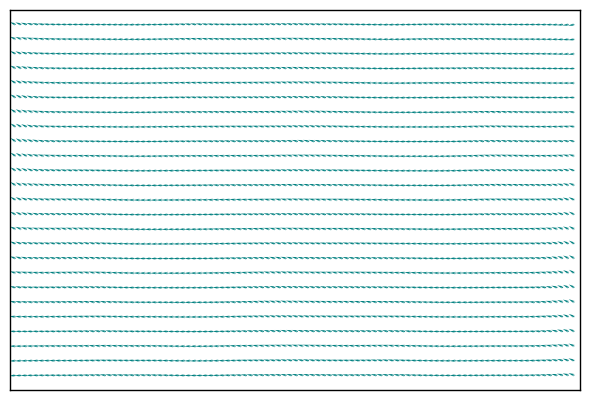

In [39]:
def plot_m (m, k = 1):
    X, Y = np.mgrid[0:n[0], 0:n[1]]
    U = m[:,:,:,0].flatten()
    V = m[:,:,:,1].flatten()

    plt.axes([0.025, 0.025, 0.95, 0.95])

    plt.quiver(X[::k, ::k], Y[::k, ::k], U[::k], V[::k], color='Teal', headlength=7)

    plt.xlim(-1, n[0])
    plt.xticks(())
    plt.ylim(-1, n[1])
    plt.yticks(())

    plt.show()
    
plot_m(m)

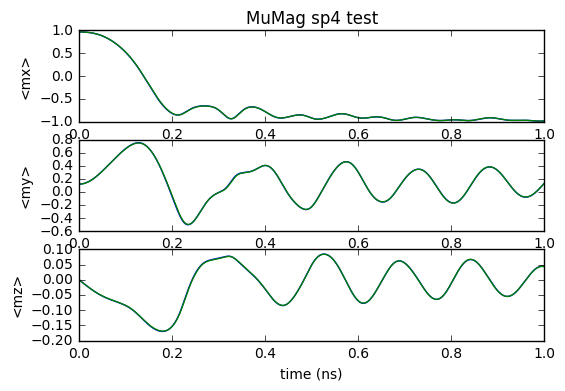

In [40]:
data = np.loadtxt('sp4_IMS.dat')
data1 = np.loadtxt("sp4.dat")

t = data[:,0]
mx = data[:,1]
my = data[:,2]
mz = data[:,3]

t1 = data1[:,0]
mx1 = data1[:,1]
my1 = data1[:,2]
mz1 = data1[:,3]

plt.subplot(3, 1, 1)
plt.plot(t, mx)
plt.plot(t1, mx1, '-')
plt.title('MuMag sp4 test')
plt.ylabel('<mx>')

plt.subplot(3, 1, 2)
plt.plot(t, my)
plt.plot(t1, my1, '-')
plt.ylabel('<my>')

plt.subplot(3, 1, 3)
plt.plot(t, mz)
plt.plot(t1, mz1, '-')
plt.ylabel('<mz>')
plt.xlabel('time (ns)')

plt.show()